In [2]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2

In [1]:

function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,2)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .2 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, R)
    # Actual parameters
    a = 1
    b = 0.25
    Dm = 0.01
    Dc = 10
    n = n

    p = (a, b, Dm, Dc, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [3]:
function simple!(dr,r,p,t)
    a, b, Dm, Dc, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
end


simple! (generic function with 1 method)

In [4]:
function run(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,600),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=(599,600))
    return sol_simp
end

run (generic function with 1 method)

In [7]:
sol10 = run(2)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 599.0
 600.0
u: 2-element Vector{Array{Float64, 3}}:
 [16.066481916425996 19.17327503656255 … 11.200781032127992 13.428827969047182; 15.50759244979292 18.484411176602546 … 10.836184154036642 12.97685317155231; … ; 16.815208819712723 20.09753853856156 … 11.687691012654218 14.033377939108702; 16.506650894650477 19.716448286729776 … 11.487238018925778 13.784365287425418;;; 0.004757403903248517 0.004710974916473182 … 0.004829938550396978 0.004796742144374893; 0.004765848630556073 0.004721290990988447 … 0.004835606300130784 0.004803646488195936; … ; 0.0047459772136995365 0.00469704094405692 … 0.0048223195899619485 0.0047873898879981945; 0.004750713317695245 0.00470283139411229 … 0.0048254591566313 0.004791274324442278]
 [16.06648190617189 19.173275028165083 … 11.200781024347078 13.428827955320932; 15.507592436828647 18.48441116884823 … 10.836184149364819 12.9768531630864; … ; 16.815208802606804 20.0975385222928 

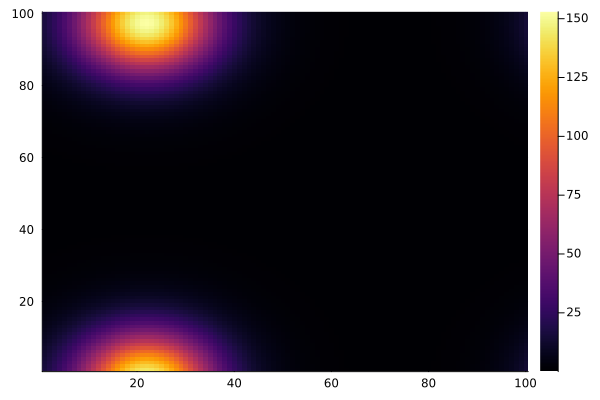

In [8]:
heatmap(sol10[:,:,1,2])

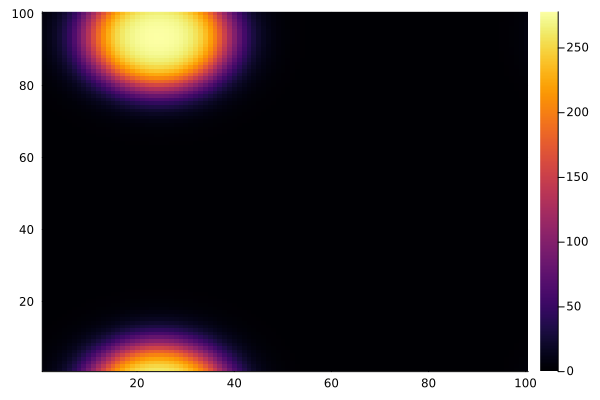

In [9]:
sol4 = run(4)
heatmap(sol4[:,:,1,2])

In [79]:
maxima = findlocalmaxima(sol3[:,:,1,end], edges=false)

2-element Vector{CartesianIndex{2}}:
 CartesianIndex(38, 6)
 CartesianIndex(94, 25)

In [82]:
sol3[:,:,1,end][maxima[2]]

242.94974210036762

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 60.0
u: 2-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817; … ; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817]
 [6.1784909987039205 8.082593039551965 … 3.591143714061327 4.713734305003043; 5.686204305325167 7.414965557989764 … 3.3263010483476756 4.352084203729992; … ; 7.0771318270155605 9.304766589293303 … 4.072198810281451 5.37215

In [17]:
seed = 0
radius=10
@save "sims/test_$(seed)_test_$(radius).jld2" sol10

In [15]:
pwd()

"/home/dionsaur/Lab/polarity"